In [58]:
import cv2
import numpy as np
import PIL
import matplotlib.pyplot as plt
import scipy.spatial.distance
import math

In [30]:
image=cv2.imread('/content/improcimg_persp.png')

In [54]:
# record image size for future
(rows,cols) = image.shape

#image center
u0 = (cols)/2.0
v0 = (rows)/2.0

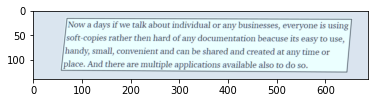

In [31]:
plt.imshow(image)

In [32]:
image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

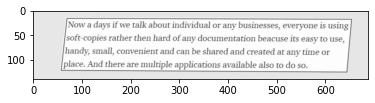

In [33]:
image_rgb=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

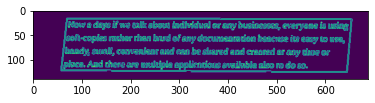

In [34]:
canny_image=cv2.Canny(image,100,200)
plt.imshow(canny_image)

[59, 120]
[71, 18]
[653, 21]
[642, 124]
[ 59. 120.   1.]
[71. 18.  1.]
[653.  21.   1.]
[642. 124.   1.]
[583, 1905]


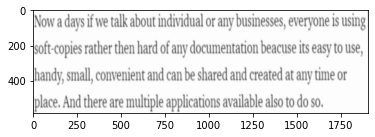

In [62]:
(contours, _) = cv2.findContours(canny_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
# a function named rectify is created to to reshape or rectify the image.
def rectify(h):
  h = h.reshape((4,2))
  hnew = np.zeros((4,2),dtype = np.float32)
  add = h.sum(1)
  hnew[0] = h[np.argmin(add)]
  hnew[2] = h[np.argmax(add)]
  diff = np.diff(h,axis = 1)
  hnew[1] = h[np.argmin(diff)]
  hnew[3] = h[np.argmax(diff)]
  return hnew
# It is obvious that if any image is clicked at a random angle it will definately have background and some other pictures and
# images also but we need to specify that detection should be done for the paper or document only. So the vertix size 4 is chosen
# of contour points.
for c in contours:
  p = cv2.arcLength(c, True)
  approx = cv2.approxPolyDP(c, 0.02 * p, True)
  # gives vertices size 4 means if vertices are 4 of any contour take that
  if len(approx) == 4:
    target = approx
    break

x_ax = 1800
y_ax = 600

# --- caluclating the aspect ratio ---
# https://www.microsoft.com/en-us/research/uploads/prod/2016/11/Digital-Signal-Processing.pdf

# mn are the points detected on the image (corners)
(m1, m2, m3, m4) = *approx.tolist()[0], *approx.tolist()[1], *approx.tolist()[2], *approx.tolist()[3]

print(m1)
print(m2)
print(m3)
print(m4)

# m1--------------m4
# |               |
# |               |
# m2--------------m3

w1 = scipy.spatial.distance.euclidean(m1, m4)
w2 = scipy.spatial.distance.euclidean(m2, m3)
h1 = scipy.spatial.distance.euclidean(m1, m2)
h2 = scipy.spatial.distance.euclidean(m4, m3)

w = max(w1, w2)
h = max(h1, h2)

# apparent aspect ratio in the image
ar_vis = float(w)/float(h)

m1 = np.array((m1[0], m1[1], 1)).astype('float32')
m2 = np.array((m2[0], m2[1], 1)).astype('float32')
m3 = np.array((m3[0], m3[1], 1)).astype('float32')
m4 = np.array((m4[0], m4[1], 1)).astype('float32')

print(m1)
print(m2)
print(m3)
print(m4)

k2 = np.dot(np.cross(m1, m4), m3) / np.dot(np.cross(m2, m4), m3)
k3 = np.dot(np.cross(m1, m4), m2) / np.dot(np.cross(m3, m4), m2)

n2 = k2 * m2 - m1
n3 = k3 * m3 - m1

n21 = n2[0]
n22 = n2[1]
n23 = n2[2]

n31 = n3[0]
n32 = n3[1]
n33 = n3[2]

f = math.sqrt(np.abs( (1.0/(n23*n33)) * ((n21*n31 - (n21*n33 + n23*n31)*u0 + n23*n33*u0*u0) + (n22*n32 - (n22*n33+n23*n32)*v0 + n23*n33*v0*v0))))

A = np.array([[f,0,u0],[0,f,v0],[0,0,1]]).astype('float32')

At = np.transpose(A)
Ati = np.linalg.inv(At)
Ai = np.linalg.inv(A)

#calculate the real aspect ratio
ar_real = math.sqrt(np.dot(np.dot(np.dot(n2,Ati),Ai),n2)/np.dot(np.dot(np.dot(n3,Ati),Ai),n3))

if ar_real < ar_vis:
    W = int(w)
    H = int(W / ar_real)
else:
    H = int(h)
    W = int(ar_real * H)

print([W, H])

# -- mapping target points to the appropriate h and w

x_ax = H
y_ax = W

approx = rectify(target)
pts2 = np.float32([[0, 0], [x_ax, 0], [x_ax, y_ax], [0, y_ax]])
M = cv2.getPerspectiveTransform(approx,pts2)
final_image = cv2.warpPerspective(image_rgb,M,(x_ax, y_ax)) # w, h
#cv2.drawContours(image, [target], -1, (0, 255, 0), 2)
plt.imshow(final_image)

## Adaptive Thresholding

In [78]:
final_image = cv2.adaptiveThreshold(final_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11)

TypeError: ignored

## Text detection and OCR

In [63]:
! apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 11 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (29.7 MB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 144628 files and directories currently installed.)
Preparing to unpack .../tesseract

In [64]:
! apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libleptonica-dev
The following NEW packages will be installed:
  libleptonica-dev libtesseract-dev
0 upgraded, 2 newly installed, 0 to remove and 11 not upgraded.
Need to get 2,755 kB of archives.
After this operation, 13.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libleptonica-dev amd64 1.75.3-3 [1,308 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libtesseract-dev amd64 4.00~git2288-10f4998a-2 [1,447 kB]
Fetched 2,755 kB in 0s (19.6 MB/s)
Selecting previously unselected package libleptonica-dev.
(Reading database ... 144675 files and directories currently installed.)
Preparing to unpack .../libleptonica-dev_1.75.3-3_amd64.deb ...
Unpacking libleptonica-dev (1.75.3-3) ...
Selecting previously unselected package libtesseract-dev.
Preparing to unpack .../libtes

In [65]:
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.6-py2.py3-none-any.whl size=13629 sha256=42e85da8b0d059bdec979b1e7babf5914a4ef88d9f514196ccfa9e1d506fb315
  Stored in directory: /root/.cache/pip/wheels/ee/71/72/b98430261d849ae631e283dfc7ccb456a3fb2ed2205714b63f
Successfully built pytesseract


In [66]:
import pytesseract

In [67]:
ocrimage=final_image

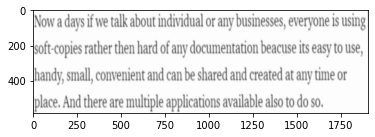

In [68]:
grayocrimage = cv2.cvtColor(ocrimage,cv2.COLOR_BGR2GRAY)
grayocrimage = cv2.cvtColor(grayocrimage,cv2.COLOR_BGR2RGB)
plt.imshow(grayocrimage)



In [69]:
from pytesseract import Output

In [70]:
results = pytesseract.image_to_data(grayocrimage, output_type=Output.DICT)
print(results)

{'level': [1, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], 'word_num': [0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 0, 1,

In [71]:
results = pytesseract.image_to_string(grayocrimage)
print(results)

Now a days if we talk about individual or any businesses, everyone is using
soft-copies rather then hard of any documentation beacuse its easy to use,
handy, small, convenient and can be shared and created at any time or
place, And there are multiple applications available also to do so.



Confidence: 65
Text: 2.

Confidence: 96
Text: Reduce

Confidence: 96
Text: the

Confidence: 95
Text: context

Confidence: 96
Text: free

Confidence: 93
Text: grammar

Confidence: 69
Text: G=({A,

Confidence: 55
Text: B.C,

Confidence: 68
Text: D,

Confidence: 89
Text: E},

Confidence: 45
Text: {0,

Confidence: 96
Text: into

Confidence: 96
Text: Chomsky

Confidence: 96
Text: normal

Confidence: 96
Text: form,

Confidence: 96
Text: where

Confidence: 96
Text: the

Confidence: 93
Text: productions

Confidence: 93
Text: P

Confidence: 97
Text: are

Confidence: 96
Text: defined

Confidence: 93
Text: as

Confidence: 93
Text: P={A

Confidence: 61
Text: >

Confidence: 28
Text: 0ABC|BCD|2|IB|2DE.

Confidence: 50
Text: >2,E>}}.

Confidence: 57
Text: [5]



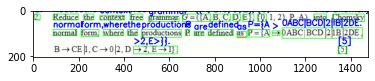

In [ ]:
for i in range(0, len(results["text"])):
  x = results["left"][i]
  y = results["top"][i]
  w = results["width"][i]
  h = results["height"][i]
  text = results["text"][i]
  conf = int(results["conf"][i])
  if conf > 20:
    print("Confidence: {}".format(conf))
    print("Text: {}".format(text))
    print("")
    text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
    cv2.rectangle(ocrimage, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(ocrimage, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,1.2, (0, 0, 255), 3)

plt.imshow(ocrimage)